**PROVIDE PERSISTENT STORAGE FOR MULTIPLE CONTAINER ORCHESTRATORS USING THE HPE EZMERAL DATA FABRIC**  
Dirk Derichsweiler, Christian Neundorf, Philipp Koik - March 2021

this file is hosted on GitHub: https://github.com/dderichswei/TSS2021-EZM1182

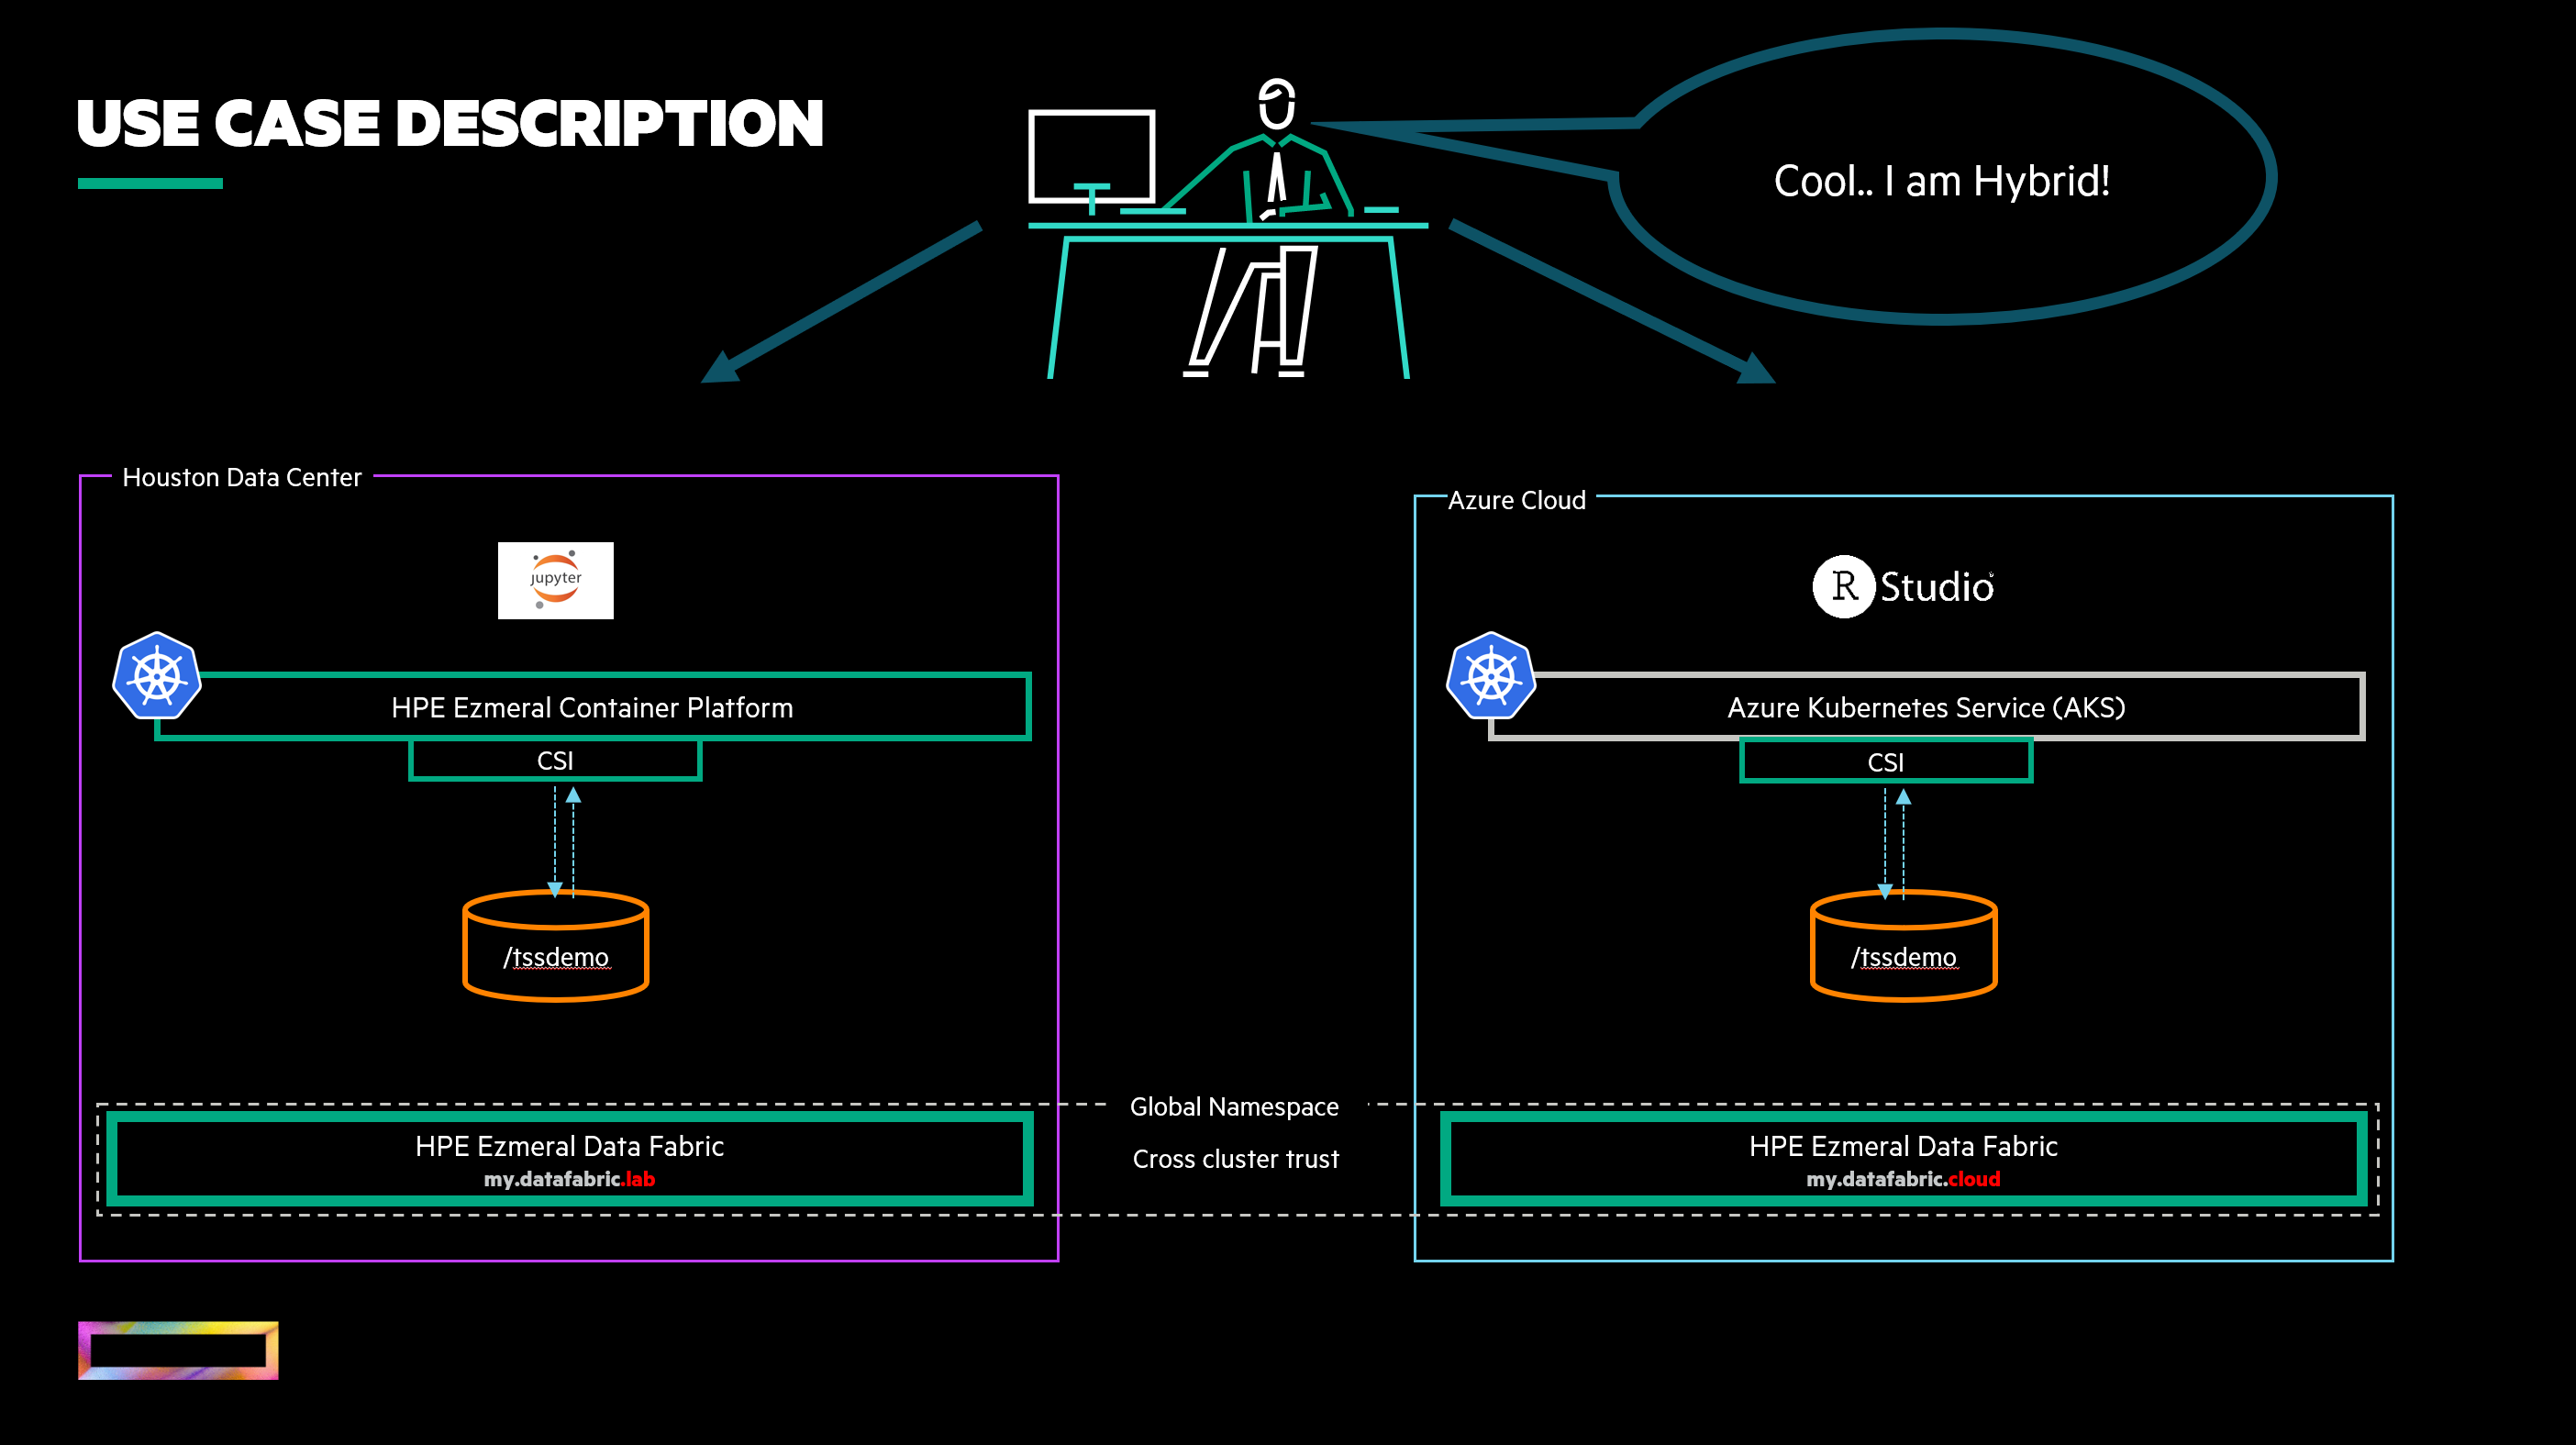

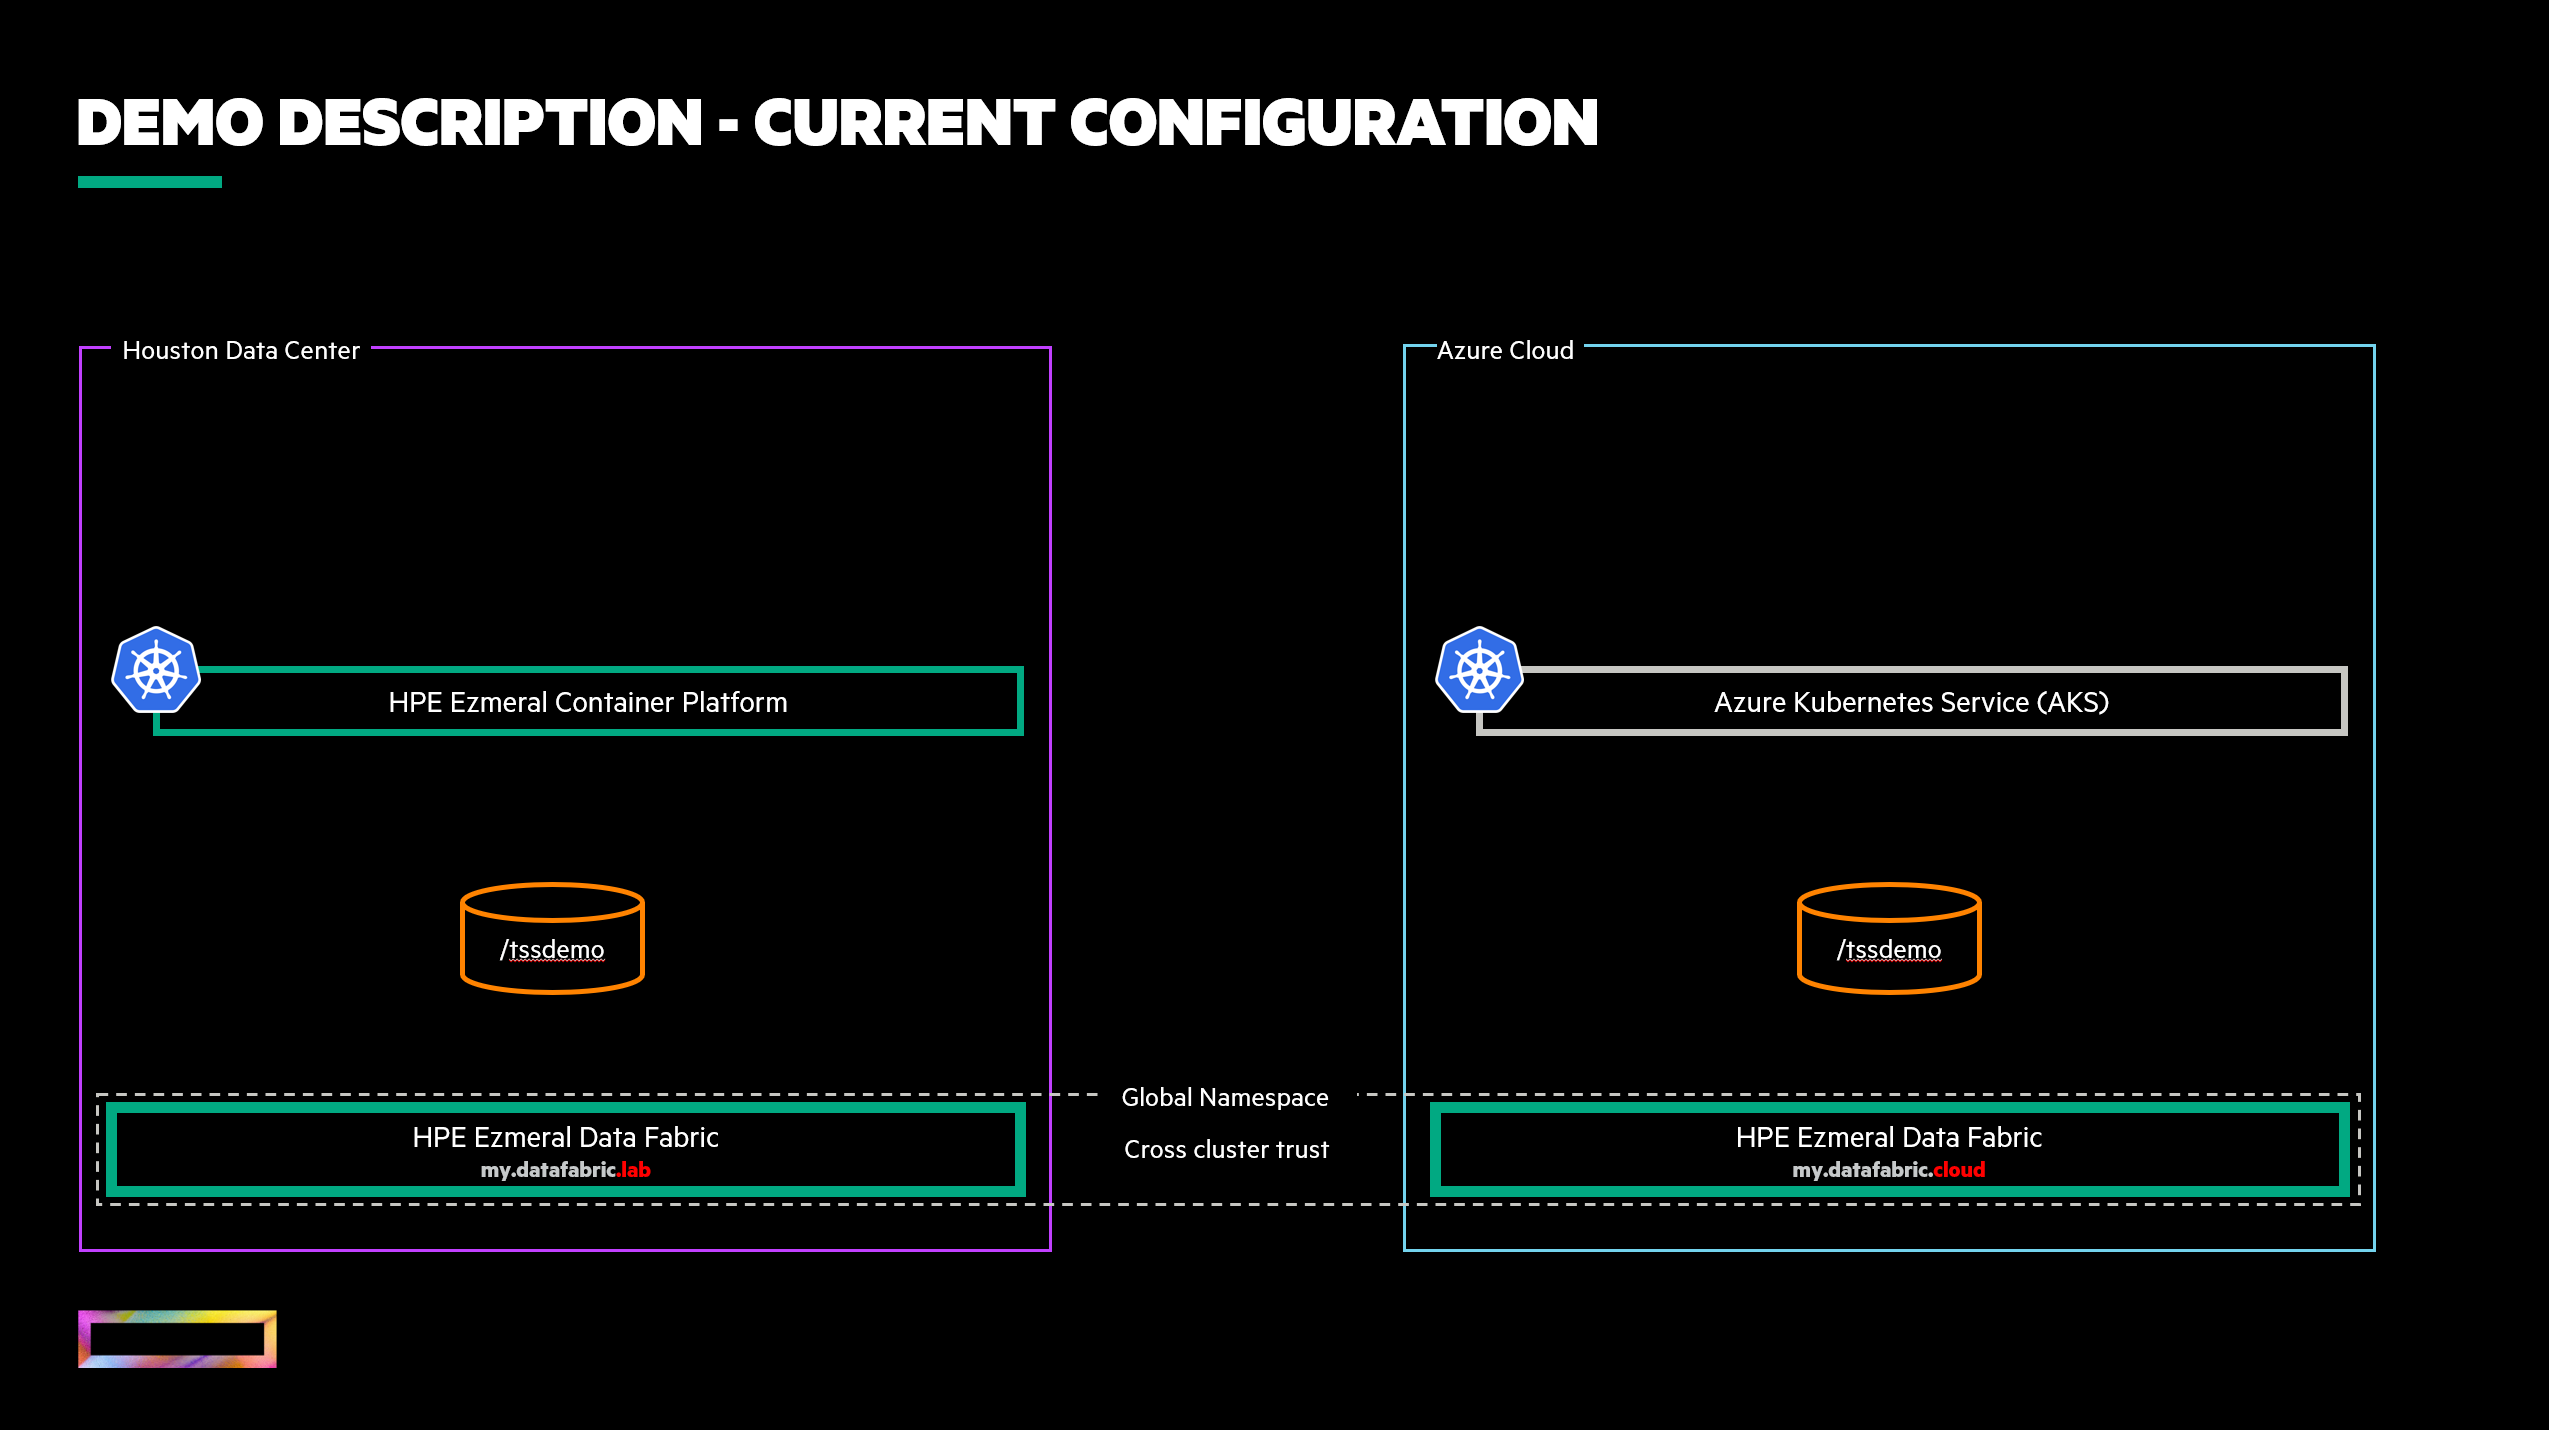

# HPE Ezmeral Datafabric CSI Installation on HPE Ezmeral Container Platform in the Houston Data Center

*select the right container platform*

## connect to Azure (AKS)

In [ ]:
export KUBECONFIG=~/k8s/TSS2021/aks-azure.conf      # connect to Azure Cloud
#export KUBECONFIG=~/k8s/TSS2021/ezmeral-houston.conf    # connect to Ezmeral Container Platform (Houston)
kubectl get nodes -o wide

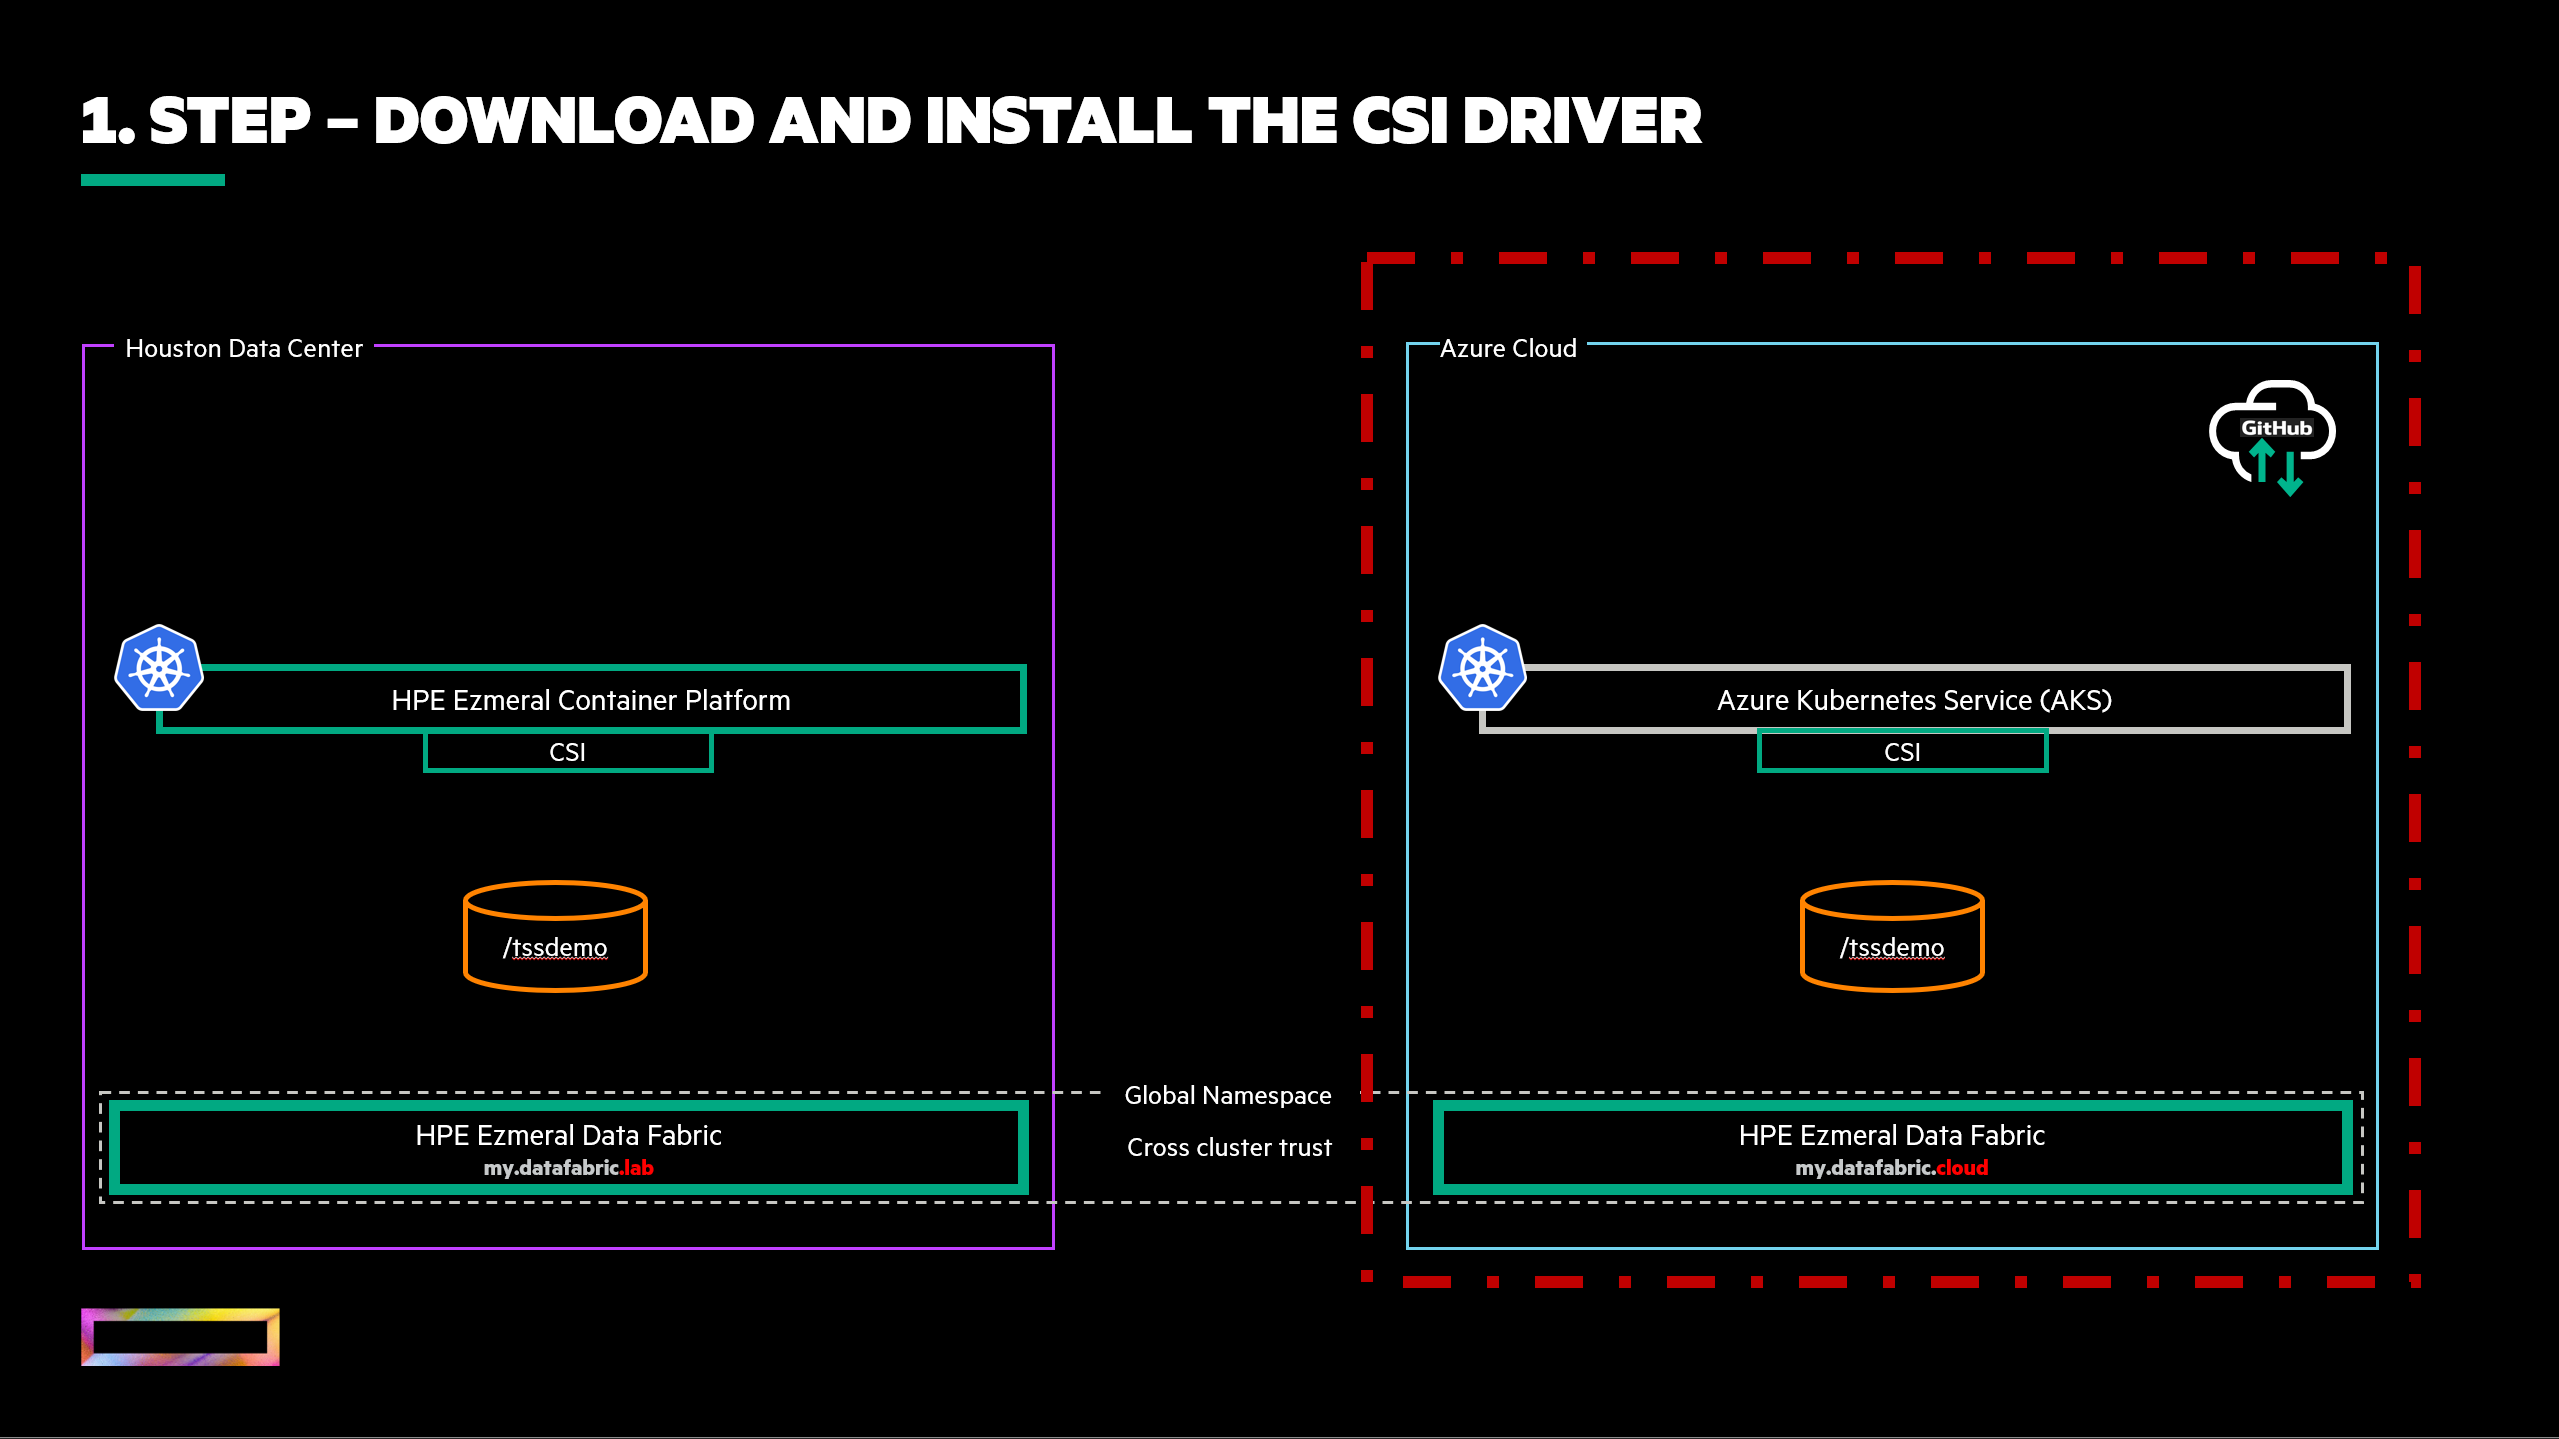

## Download the Ezmeral DataFabric-CSI driver (mapr) from github

In [ ]:
git clone https://github.com/mapr/mapr-csi.git 2>/dev/null || echo "Files already exists..."

In [ ]:
kubectl apply -f $PWD/mapr-csi/deploy/kubernetes/csi-maprkdf-v1.2.0.yaml

**DONE...**

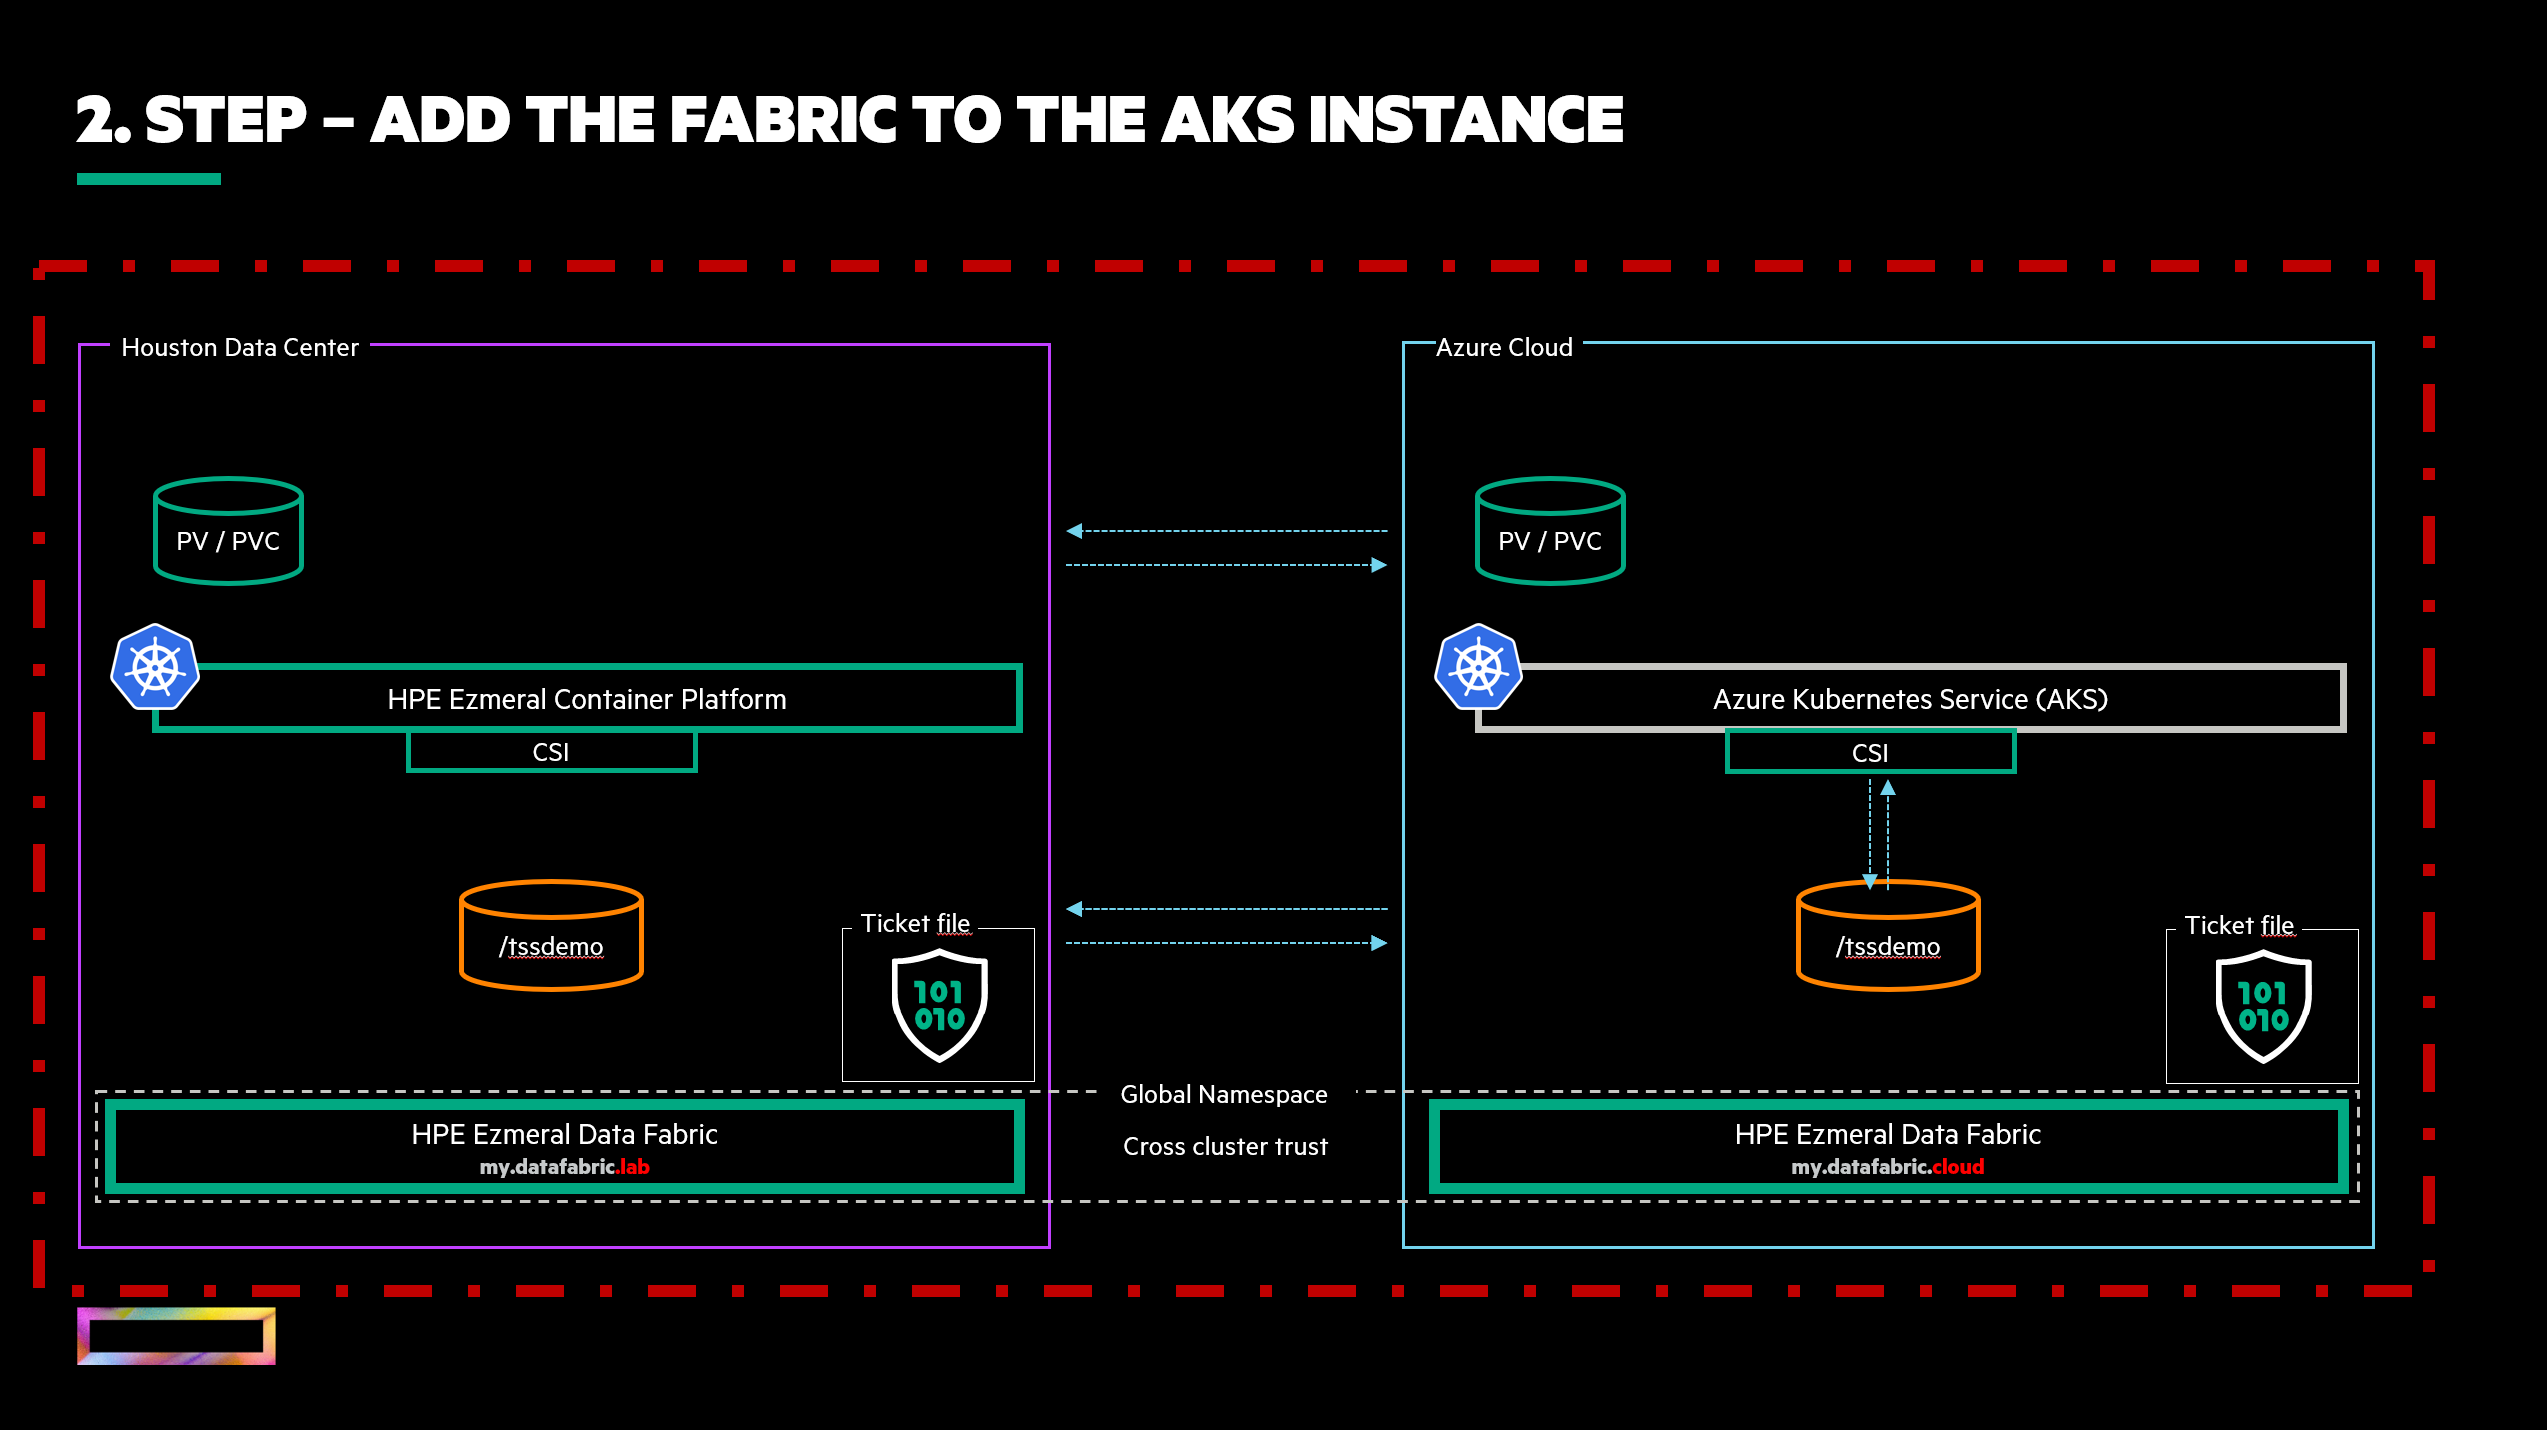

## create a Ticket

**login onto the MapR cluster and execute following:**

```bash
maprlogin password -user mapr
base64 -w 0 /tmp/maprticket_####
```

**copy the base64 encoded ticket into the CONTAINER_TICKET line.**


*example:*

In [ ]:
base64 -w0 ticket.houston_datafabric
#base64 -w0 ticket.azure_datafabric

# let´s add the Houston Datafabric and the Azure Datafabric to our HPE Ezmeral Container Platform

MapR provides a native authentication mechanism that operates equivalently to Kerberos but offers a much-simplified configuration, eliminating the need to manage the Kerberos keytab files, due to the MapR system managing the keys automatically.   
Similar to Kerberos, the user will first request a ticket from the MapR CLDB server, using a username and password that is validated, leveraging PAM interface, and then the ticket is used as a trusted identifier to all the services within MapR.

In [ ]:
cat << EOF | kubectl apply -f -

# MapR Apps Namespace
---
apiVersion: v1
kind: Namespace
metadata:
  name: mapr-apps

# Ticket to authenticate with HPE Container Platform internal Data Fabric
---
apiVersion: v1
kind: Secret
metadata:
  name: mapr-ticket-houston-secret
  namespace: mapr-apps
type: Opaque
data:
  CONTAINER_TICKET: $(base64 -w0 ticket.houston_datafabric)

# Ticket to authenticate with external Data Fabric
---
apiVersion: v1
kind: Secret
metadata:
  name: mapr-ticket-azure-secret
  namespace: mapr-apps
type: Opaque
data:
  CONTAINER_TICKET: $(base64 -w0 ticket.azure_datafabric)


EOF

In [ ]:
kubens mapr-apps

## create Persistent Volume and Persistent Volume Claim

In [ ]:
cat << EOF | kubectl apply -f -

---      
# Create PVC on External Data Fabric      
apiVersion: v1
kind: PersistentVolume
metadata:
  name: pv-mapr-apps-external
  namespace: mapr-apps
spec:
  capacity:
    storage: 5Gi
  accessModes:
    - ReadWriteMany
  persistentVolumeReclaimPolicy: Retain
  claimRef:
    namespace: mapr-apps
    name: pvc-mapr-apps-external
  csi:
    nodePublishSecretRef:
      name: "mapr-ticket-azure-secret"
      namespace: "mapr-apps"
    driver: com.mapr.csi-kdf
    volumeHandle: k8s-dynamic-cloud
    volumeAttributes:
      volumePath: "/tssdemo"
      cluster: "my.datafabric.cloud"
      cldbHosts: "172.24.8.8"
      securityType: "secure"
      #platinum: "true"      

 
# # Create PVC for external Data Fabric
---
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: pvc-mapr-apps-external
  namespace: mapr-apps
spec:
  accessModes:
    - ReadWriteMany
  resources:
    requests:
      storage: 5G



# NOW we repeat the same commands for the Houston Datafabric
---
# Create Persistent Volume on Internal Data Fabric
apiVersion: v1
kind: PersistentVolume
metadata:
  name: pv-mapr-apps
  namespace: mapr-apps
spec:
  capacity:
    storage: 5Gi
  accessModes:
    - ReadWriteMany
  persistentVolumeReclaimPolicy: Retain
  claimRef:
    namespace: mapr-apps
    name: pvc-mapr-apps
  csi:
    nodePublishSecretRef:
      name: "mapr-ticket-houston-secret"
      namespace: "mapr-apps"
    driver: com.mapr.csi-kdf
    volumeHandle: k8s-dynamic-lab
    volumeAttributes:
      volumePath: "/tssdemo"
      cluster: "my.datafabric.lab"
      cldbHosts: "10.92.3.7"
      securityType: "secure"
      #platinum: "true"   


# Create PVC for internal Data Fabric
---
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: pvc-mapr-apps
  namespace: mapr-apps
spec:
  accessModes:
    - ReadWriteMany
  resources:
    requests:
      storage: 5G

EOF

In [ ]:
kubectl get pv,pvc

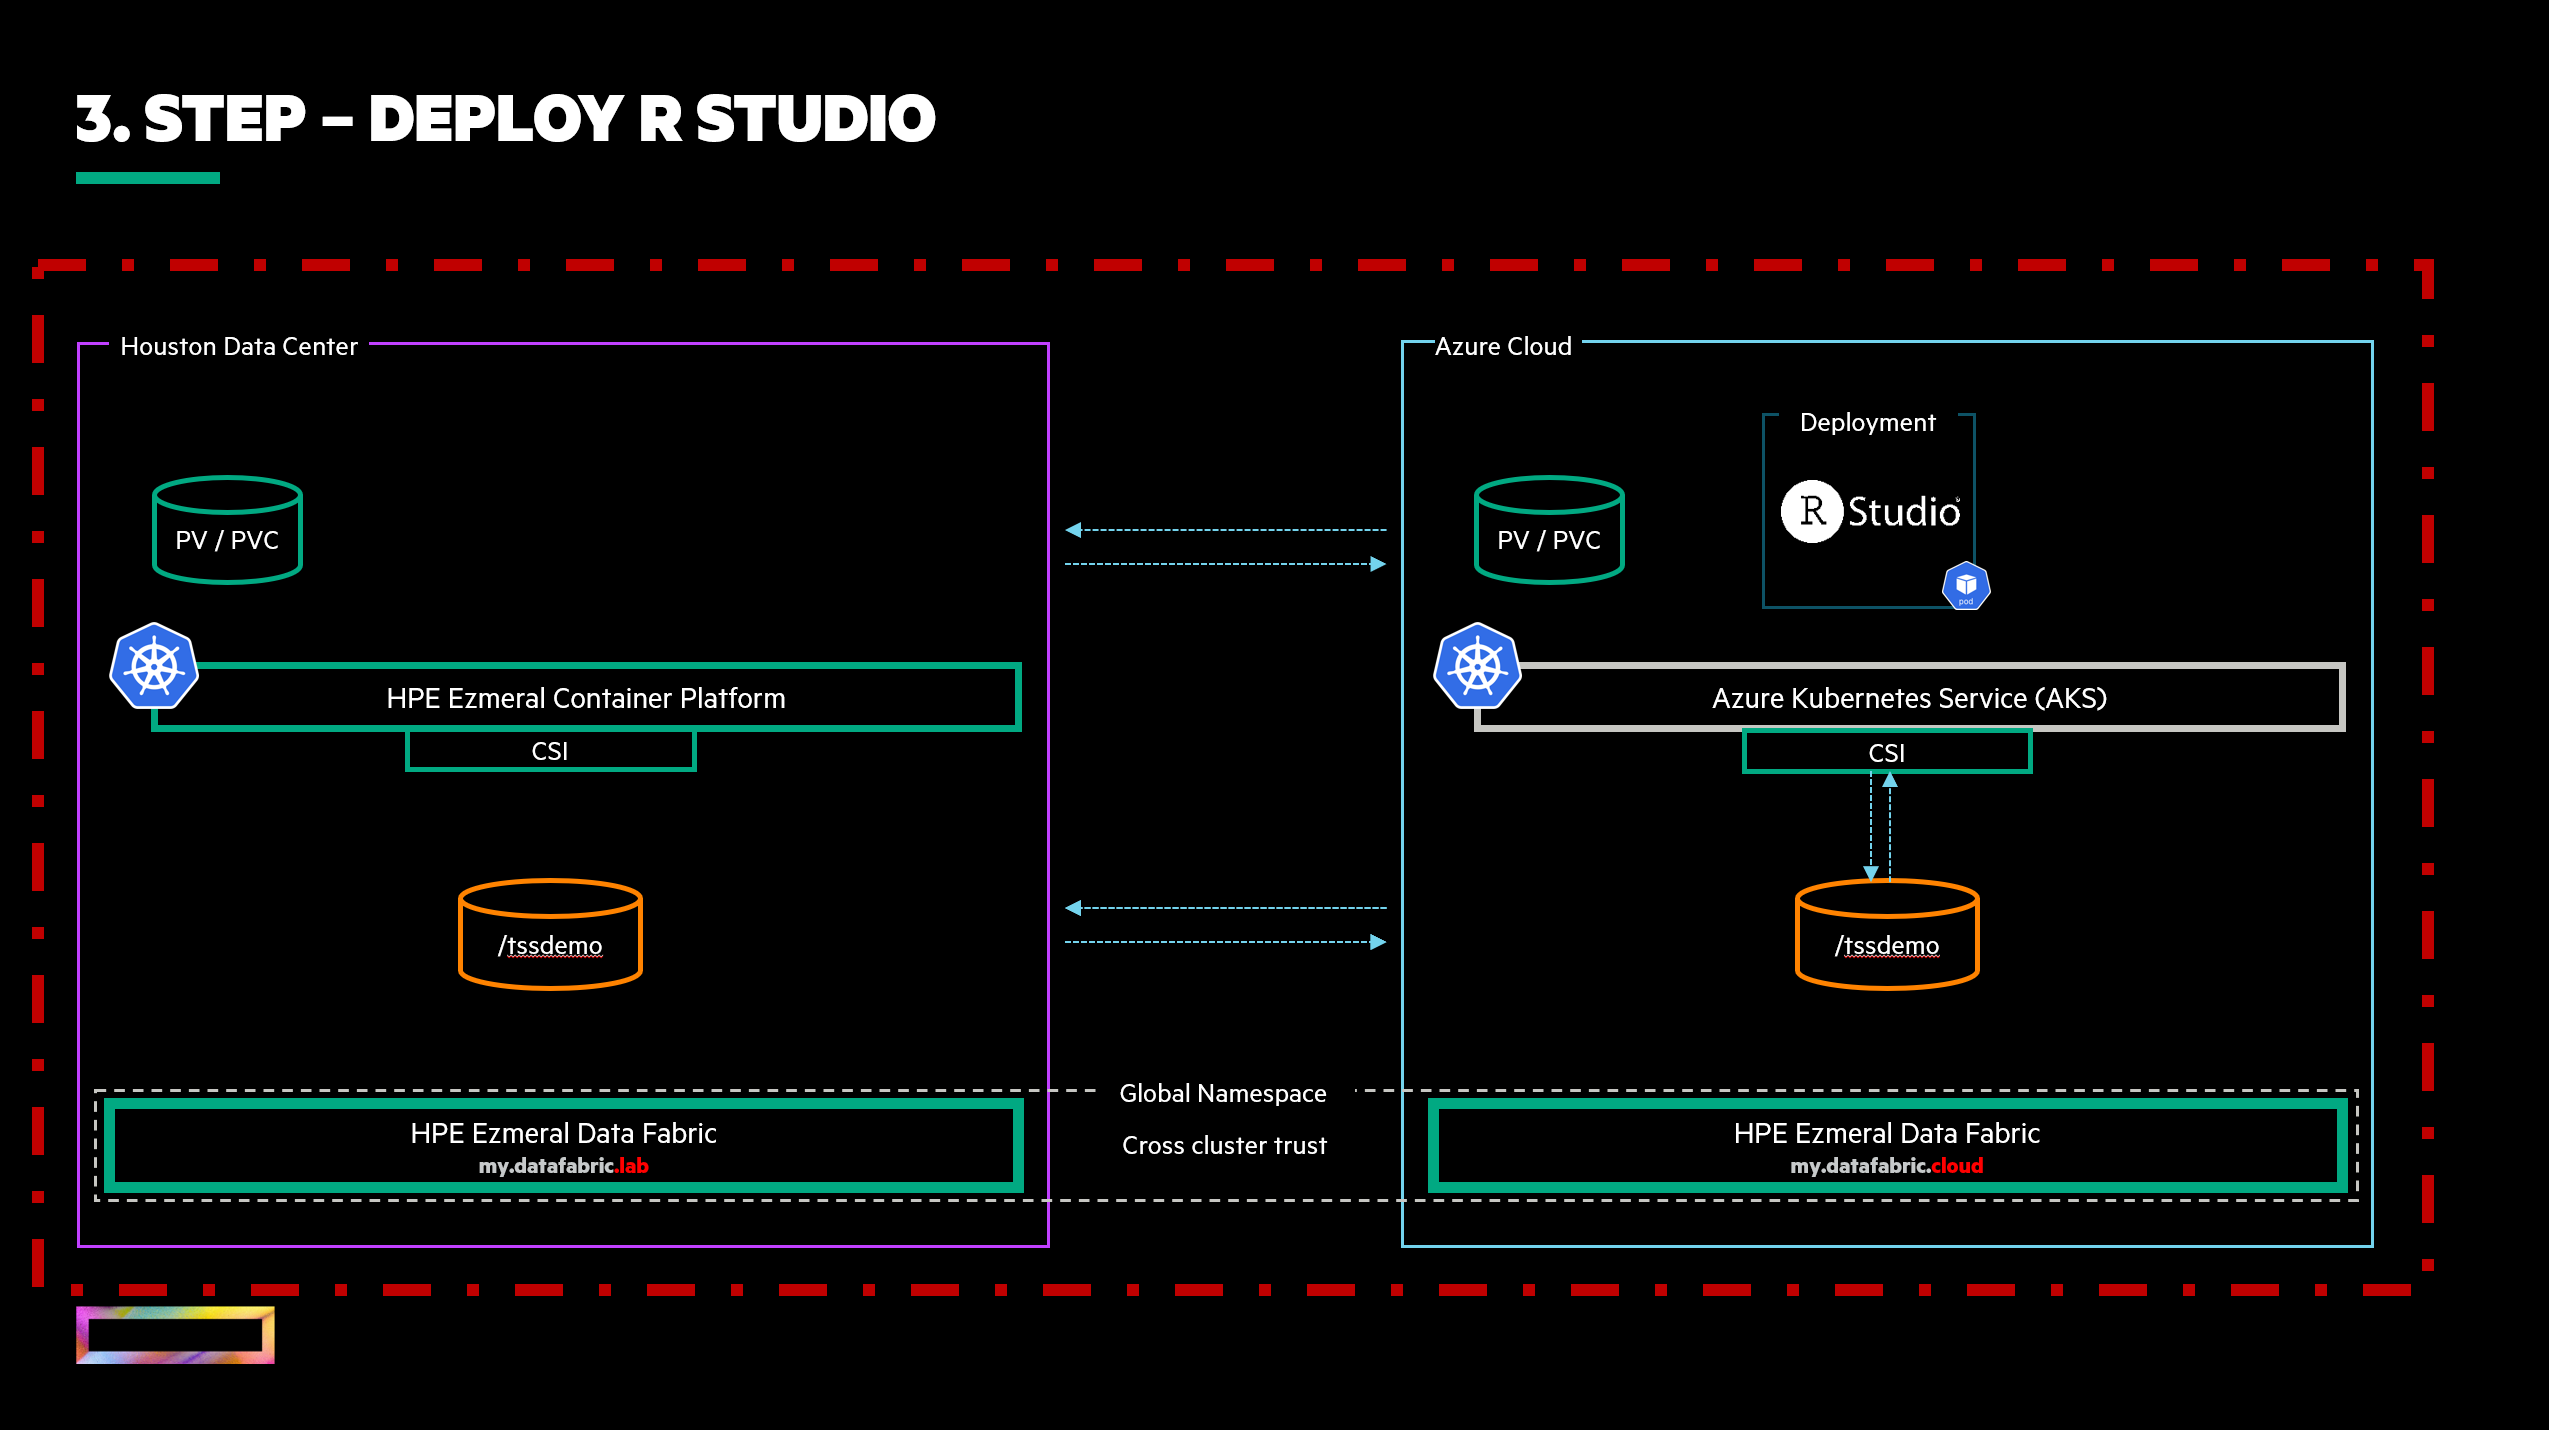

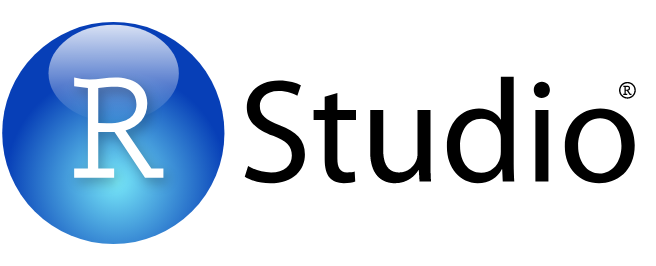

In [ ]:
#try rstudio
cat << 'EOF' | kubectl apply -f -
apiVersion: apps/v1
kind: Deployment
metadata:
 name: rstudio-demo
 namespace: mapr-apps
spec:
  selector:
    matchLabels:
      app: rstudio-demo
  template:
    metadata:
      labels:
        app: rstudio-demo
    spec:
       containers:
         - name: mapr-apps-rstudio
           image: rocker/rstudio:3.2.0
           imagePullPolicy: IfNotPresent 
           env:
           - name: PASSWORD
             value: "admin123"
           
           volumeMounts:
             - mountPath: /mapr/my.datafabric.lab
               name: maprvolume
             - mountPath: /mapr/my.datafabric.cloud
               name: maprvolume-external
         
       volumes:
        - name: maprvolume
          persistentVolumeClaim:
           claimName: pvc-mapr-apps
        - name: maprvolume-external
          persistentVolumeClaim:
           claimName: pvc-mapr-apps-external
EOF

In [ ]:
cat << 'EOF' | kubectl apply -f - 
apiVersion: v1
kind: Service
metadata:
  name: rstudio
  namespace: mapr-apps

spec:
  selector: 
    app: rstudio-demo
  ports:
  - name: rstudio-port
    port: 8787
    targetPort: 8787
  type: NodePort
EOF

In [ ]:
kubectl get svc rstudio
kubectl get nodes -o wide

In [ ]:
kubectl get svc rstudio -o yaml | grep hpecp-internal-gateway/8787

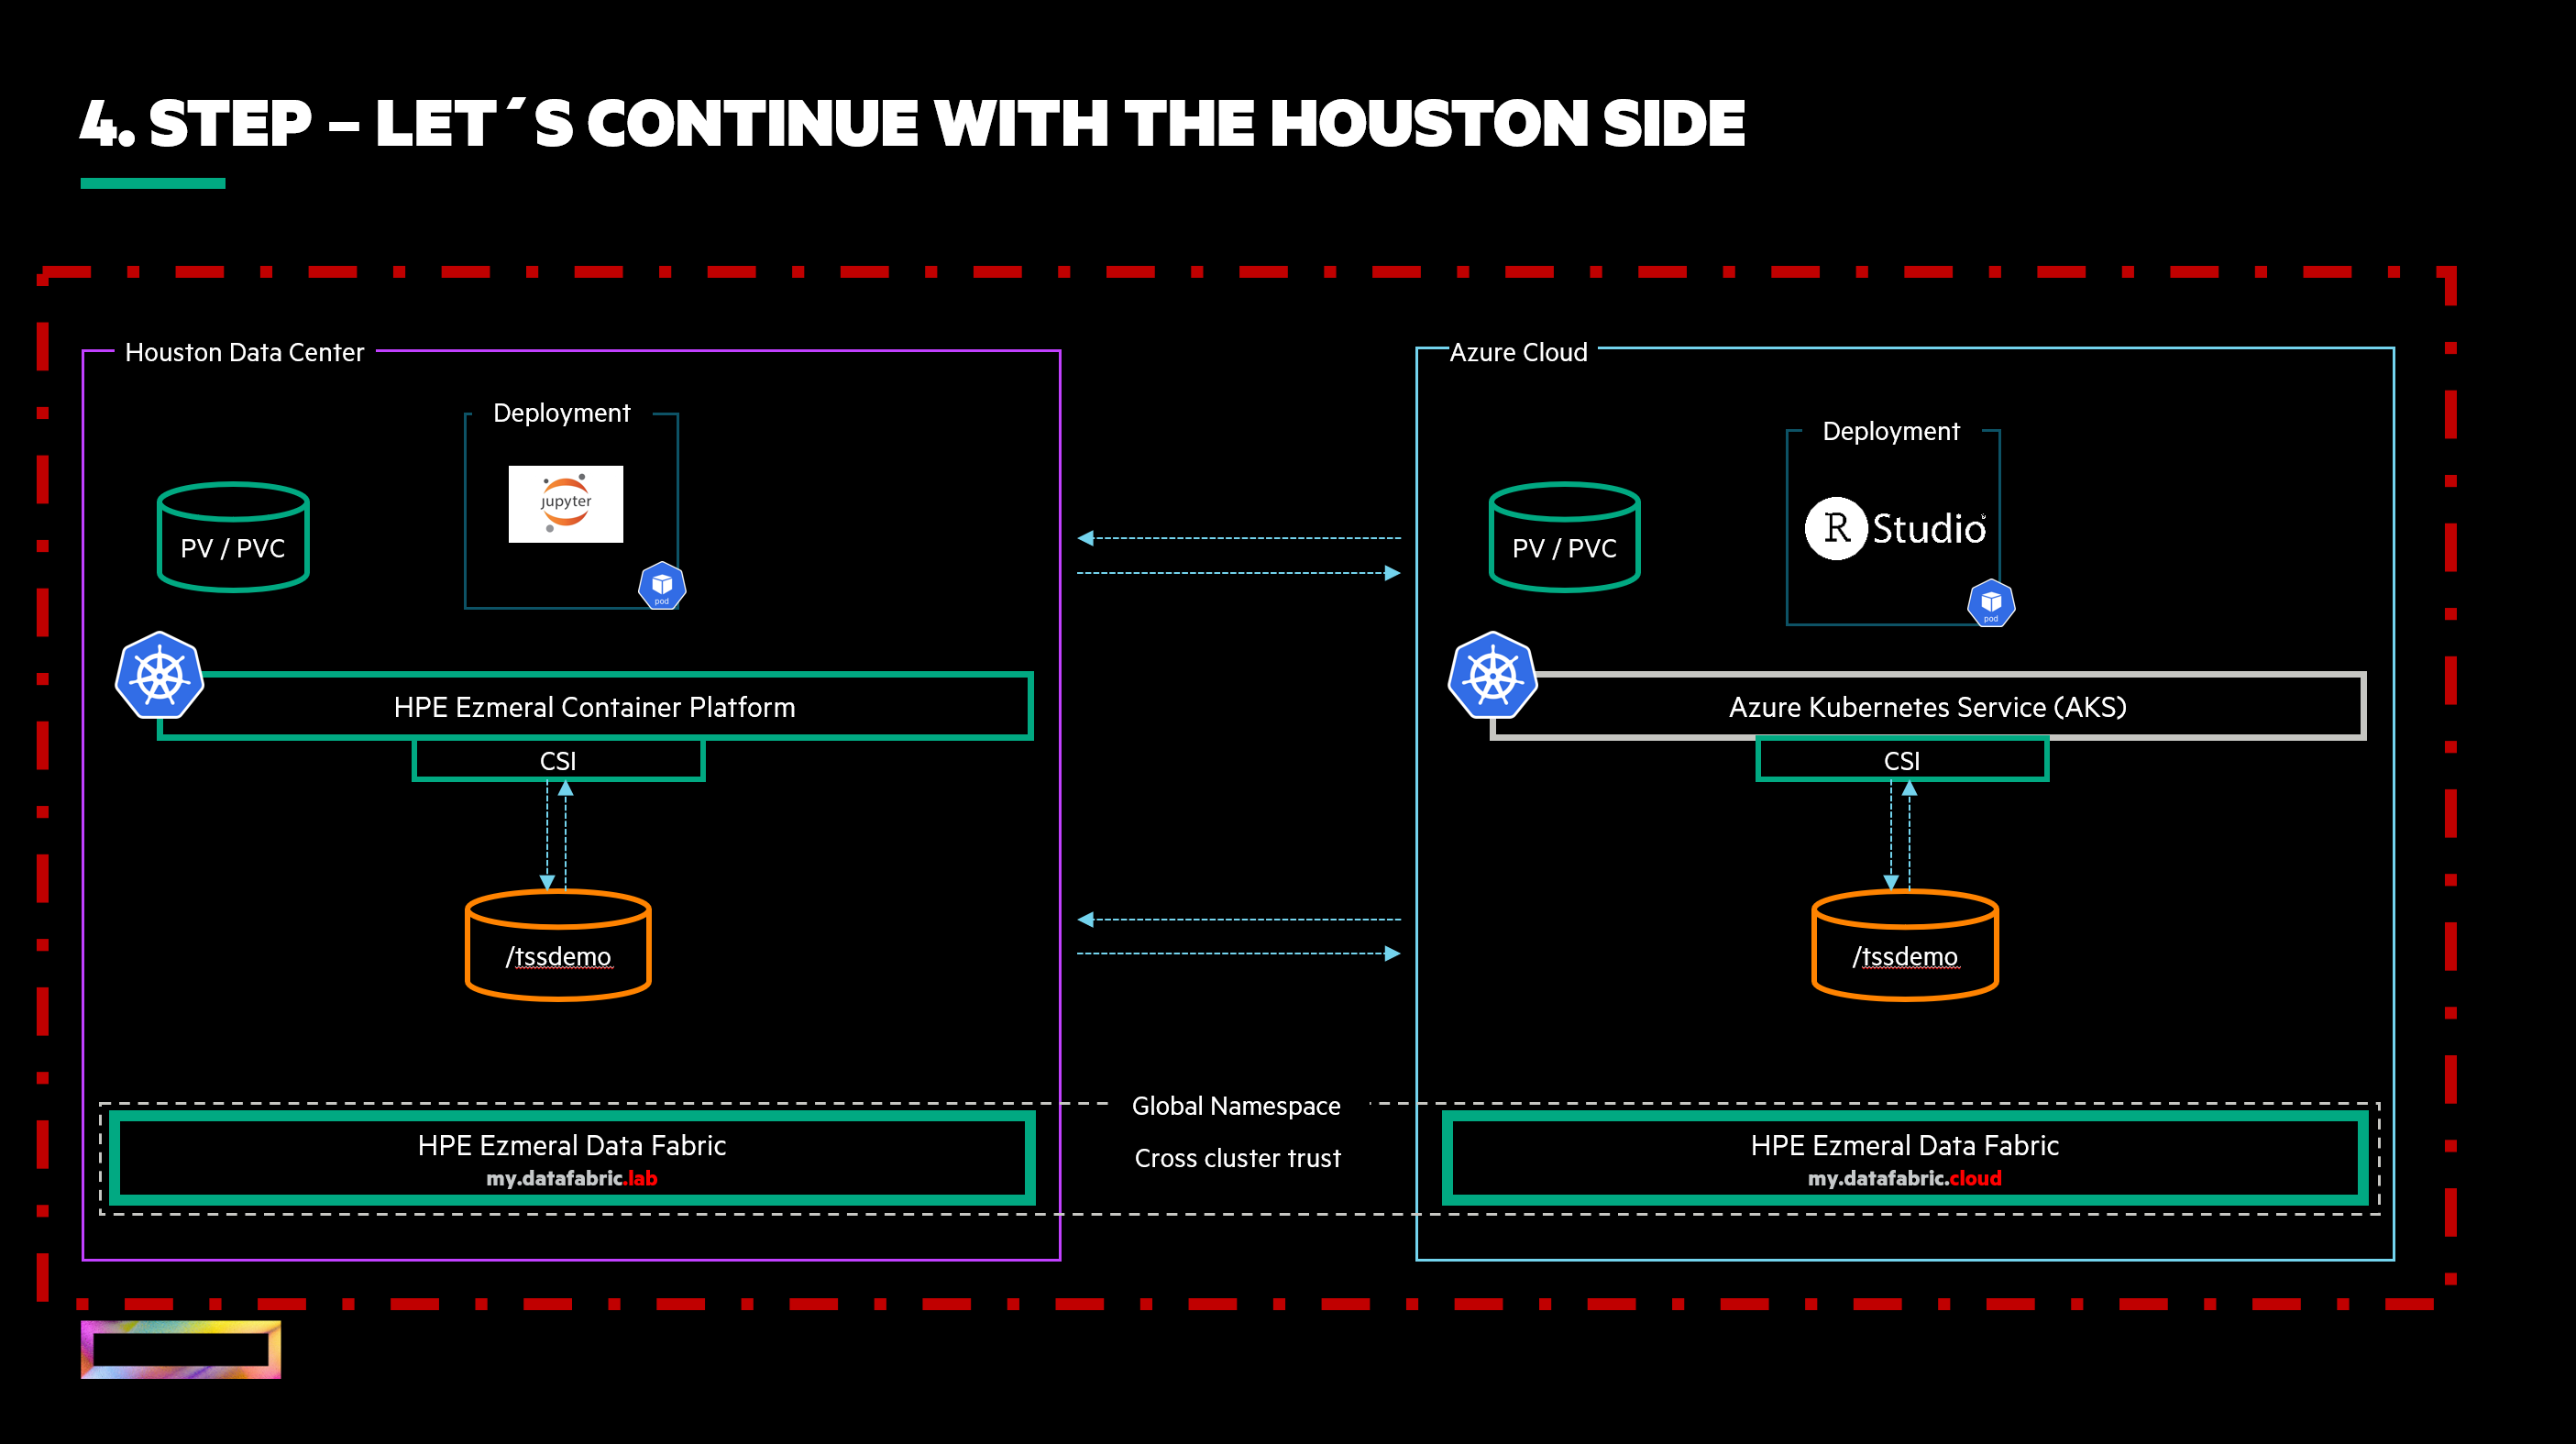

# Deploy Houston Side

In [ ]:
export KUBECONFIG=~/k8s/TSS2021/ezmeral-houston.conf    # connect to Ezmeral Container Platform (Houston)
kubectl get nodes -o wide

In [ ]:
#try rstudio
cat << 'EOF' | kubectl apply -f -
apiVersion: apps/v1
kind: Deployment
metadata:
 name: ddjupyter
 namespace: mapr-apps
spec:
  selector:
    matchLabels:
      app: ddjupyter
  template:
    metadata:
      labels:
        app: ddjupyter

    spec:
       containers:
         - name: ddjupyter
           image: jupyter:latest
           imagePullPolicy: IfNotPresent 
           
           volumeMounts:
             - mountPath: /home/dderichswei/mapr/my.datafabric.lab
               name: maprvolume
             - mountPath: /home/dderichswei/mapr/my.datafabric.cloud
               name: maprvolume-external
         
       volumes:
        - name: maprvolume
          persistentVolumeClaim:
           claimName: pvc-mapr-apps
        - name: maprvolume-external
          persistentVolumeClaim:
           claimName: pvc-mapr-apps-external
EOF

In [ ]:
cat << 'EOF' | kubectl apply -f - 
apiVersion: v1
kind: Service
metadata:
  name: ddjupyter
  namespace: mapr-apps
  labels:
    hpecp.hpe.com/hpecp-internal-gateway: "true"
spec:
  selector: 
    app: ddjupyter
  ports:
  - name: ddjupyter
    port: 8888
    targetPort: 8888
  type: NodePort
EOF

In [ ]:
kubectl get pods
kubectl get events

In [ ]:
kubectl get svc  ddjupyter
kubectl get nodes -o  wide

# Reset Environment

In [ ]:
export KUBECONFIG=~/k8s/TSS2021/aks-azure.conf      # connect to Azure Cloud
#export KUBECONFIG=~/k8s/TSS2021/ezmeral-houston.conf    # connect to Ezmeral Container Platform (Houston)
kubectl get nodes -o wide

In [ ]:
kubectl delete svc rstudio -n mapr-apps
kubectl delete deployment rstudio-demo -n mapr-apps
kubectl delete pvc pvc-mapr-apps-external pvc-mapr-apps -n mapr-apps
kubectl delete pv pv-mapr-apps-external pv-mapr-apps -n mapr-apps
kubectl delete secret mapr-ticket-azure-secret mapr-ticket-houston-secret -n mapr-apps
kubectl delete namespace mapr-apps
kubectl delete -f $PWD/mapr-csi/deploy/kubernetes/csi-maprkdf-v1.2.0.yaml
sudo rm -r mapr-csi

# Check Volume Attachment

In [ ]:
kubectl get volumeattachment